In [3]:
# default_exp experiment_2
%load_ext autoreload
%autoreload 2

## Experiment 2 Rerun: OCR Learner Training 3: Match With Empirical Data Using Noise

> Rerun of E2 using noise instead of Gaussian blur for stimulus degradation as in Testolin et al. (2017). 

### Stimulus Degradation

In a preliminary experiment and related downstream experiments (E3), we used a Gaussian blur for stimulus degradation. While this had been the adopted tactic in Loomis (1982), it is problematic for machine learning. As the blur is deterministic, the model may learn to adapt to that in specific. In most of the others studies cited in Testolin et al. (2017), however, stimulus duration was used as to reach an accuracy of 50%. Testolin et al. used Gaussian noise for degradation, which we will also adopt.

It is left for future discussion, whether this is the optimal way to simulate short stimulus exposure. Clearly, we cannot directly control stimulus duration with feed-forward neural networks, although with recurrent ones this might be achieved. In terms of noise, we resort to monochrome noise, although it might argued that RGB-noise would be more accurate if short exposure is assumed to lead to stochastically incomplete accrual of photons in the retinal receptors. However, if the human confusability is more the result of noise or reduced firing of downstream neurons, perhaps noise applied directly to later layers of the neural network would be more apposite. 

In terms of noise, note that we apply it before conversion to RGB. Furthermore, we use black letters on a white background in contrast to Testolin et al. (2017) and some of the other studies cited. In human studies such a change might be more substantial due to retinal receptor function but an ANN we assume it makes little difference.

### OCR Model Training

In contrast to Testolin et al. (2017), the natural-image-trained CORnet-Z model is trained on letters in a supervised manner. Naively, this makes sense from a human learning perspective, but the main reason is technical feasibility.

### Confusion Matrix Matching

Because most of the experimental conditions of the studies cited in Testolin et al. (2017) are different from our setting with either varying degradation methods or font used, we use only the data from Van der Heijden et al. (1984). In line with prior research (e.g. Loomis, 1981; Kikuchi et al., 1979; Courrieou et al., 2004), the confusion matrix is symmetrized before use to reduce uncorrelated variation. There exists quite a lot of asymmetry in the upper and lower triangles of the matrices, which perhaps calls the validity of this approach into question when the purpose is to model human empirical data.

In an ideal case, a number of different models matching individual human subject's performance would be trained, because it is possible that averaging their results masks relevant phenomena. These could be then as an ensemble or further distilled into on model.

### Procedure

In this notebook, we will train a pretrained CORnet-Z model to match data from empirical studies with human subjects.

1. Train the Initial OCR Model
   1. Load a CORnet-Z model pretrained with ImageNet data.
   2. Fine-tune its V4, IT and Decoder layers with font and handwritten data.
2. Fine-Tune to Match Human Confusion Matrix Data
   1. Define a font dataset that is similar enough to the ones used in human studies.
   2. Find a noise level that degrades the model's performance match the 50% accuracy 
      (as measured by correct classification probability) used in human studies.
   3. Finetune the CORnet-Z model so that its output matches the propability distributions 
      from human confusion matrices instead of one-hot vectors.

## Imports

In [4]:
from aifont.core import *
from aifont.ocrlearner import *
from aifont.fontsampler import *
from fastai.data.all import *
from fastai.vision.all import *
from enum import Enum, auto
import gc
from nbdev.showdoc import *
import matplotlib.pyplot as plt
# import os
import pandas as pd
from pandas import DataFrame
# import PIL
# import random
# import re
# import scipy.io
# import string
# import torchvision.transforms.functional as VF
# import torchvision.transforms as VT
from typing import Callable, List, Sequence, Tuple

## Common Variables

In [5]:
DUMP_FOLDER = Path("results/02_experiment_2"); ensure_path(DUMP_FOLDER)
BASE_OCR_MODEL_FN = "e2_cornet_z_base_model.pth"
FINETUNED_OCR_MODEL_FN = "e2_cornet_z_v4_finetuned_final.pth"
BASE_TFMS = dict(size=48,
                 normalize=True, 
                 tfms_p=.5,
                 use_affine_tfms=True,
                 use_xtra_tfms=True,
                 blur_size=None, #(3, 9),
                 blur_sigma=None, #(1., 3.), 
                 noise_f=(.15, 2.),
                 noise_method=BlendingMethod.ADD,
                 noise_type=NoiseType.GAUSSIAN,
                 translate_and_pad=0.,
                 override_max_rotate=5.,
                 override_max_warp=0.1
                 )
ACC_50_TFMS = {'use_affine_tfms': False,
                'use_xtra_tfms': True,
                'tfms_p': 1.0,
                'blur_size': None,
                'blur_sigma': None,
                'noise_f': 1.365625,
                'noise_type': NoiseType.GAUSSIAN,
                'noise_method': BlendingMethod.ADD,
                'size': 48,
                'normalize': True,
                'translate_and_pad': 0.0
              }

## Step 1: Train the Initial OCR Model

### Create Learner

In [ ]:
df_az_and_tmnist = get_combined_az_and_tmnist_df(False)

In [ ]:
# Load this into memory as it takes a while
df_az_and_tmnist = get_combined_az_and_tmnist_df(False)
df_tmnist = get_tmnist_images()

In [4]:
def do_build_ocr_learner(
    learn_suffix: str,
    df: DataFrame,
    split_at = CornetLayer.V4,
    learn_fn = "e2_cornet_z",
    tfm_args = BASE_TFMS,
    valid_tfms = False,
    save_cb = True,
) -> tuple[Learner,str,str]:
    learn = None; gc.collect()
    base_args = dict(arch=partial(cornet_for_ocr, split_at=split_at),
                     df=df)
    learn_fn  = f"e2_cornet_z_{learn_suffix}"
    best_fn   = f"{learn_fn}_best"
    cbs = [SaveModelCallback(fname=best_fn, with_opt=True)] if save_cb else None
    learn = build_ocr_learner(**base_args,
                              **tfm_args,
                                cbs=cbs,
                                bs=256)
    if valid_tfms:
        # Apply all tfms to the validation dataset as well
        for o in learn.dls.train.after_item: o.split_idx = None
    learn.freeze()
    learn.summary()
    learn.dls.show_batch()
    return learn,learn_fn,best_fn

### Train Version 1: V4–Decoder, Fonts Only, Basic Gaussian Noise – `e2_cornet_z_v1_final.pth`

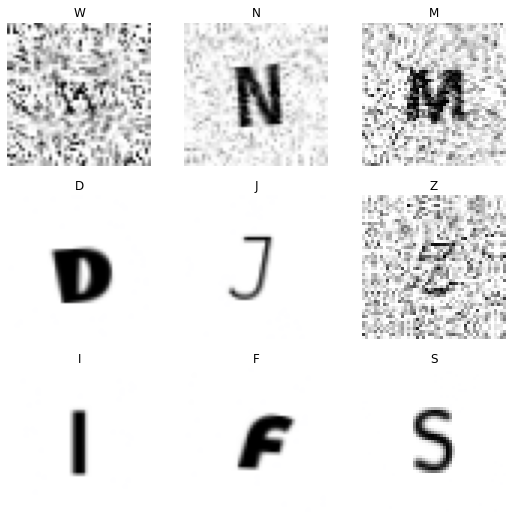

In [28]:
learn,learn_fn,best_fn = do_build_ocr_learner("v1", 
                                              df=df_tmnist,
                                              split_at=CornetLayer.V4)

In [102]:
# learn.load(best_fn) # Continue after crash
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

KeyboardInterrupt: 

In [86]:
lrs.valley

0.0020892962347716093

In [87]:
learn.fit_one_cycle(10, lrs.valley)
learn.save(f"{learn_fn}_ep10")

Better model found at epoch 0 with valid_loss value: 0.8812496066093445.
Better model found at epoch 1 with valid_loss value: 0.21777865290641785.
Better model found at epoch 2 with valid_loss value: 0.17320185899734497.
Better model found at epoch 3 with valid_loss value: 0.16480378806591034.
Better model found at epoch 4 with valid_loss value: 0.14046308398246765.
Better model found at epoch 5 with valid_loss value: 0.11899639666080475.
Better model found at epoch 6 with valid_loss value: 0.10717461258172989.
Better model found at epoch 7 with valid_loss value: 0.09579303115606308.
Better model found at epoch 8 with valid_loss value: 0.09062591195106506.
Better model found at epoch 9 with valid_loss value: 0.09040205925703049.


Path('models/e2_cornet_z_ep10.pth')

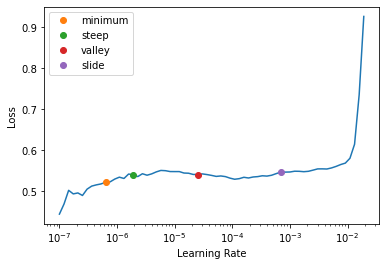

In [103]:
learn.load(best_fn)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [106]:
learn.fit_one_cycle(10, 2e-4)
learn.save(f"{learn_fn}_ep20")

Better model found at epoch 0 with valid_loss value: 0.5075280070304871.
Better model found at epoch 1 with valid_loss value: 0.5072264671325684.
Better model found at epoch 2 with valid_loss value: 0.5065721869468689.
Better model found at epoch 3 with valid_loss value: 0.4990899860858917.
Better model found at epoch 6 with valid_loss value: 0.4856951832771301.
Better model found at epoch 8 with valid_loss value: 0.47765597701072693.


In [29]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep20_best")
learn.fit_one_cycle(20, 1e-4)
learn.save(f"{learn_fn}_ep40")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep40_best")

Better model found at epoch 0 with valid_loss value: 0.06258241087198257.


Path('models/e2_cornet_z_v1_ep40_best.pth')

> It seems valid loss of 0.06258241087198257 at ep 21 is about as low as we can get. We'll save it as `e2_cornet_z_v1_final.pth`.

### Train Version 2: V2–Decoder, Fonts Only, Basic Gaussian Noise – `e2_cornet_z_v2_final.pth`

> We made two training runs, v2 and v2b, because the accuracy stays surprisingly low. Even though it was a bit better on the second run, it's still curiously bad at 0.915886.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


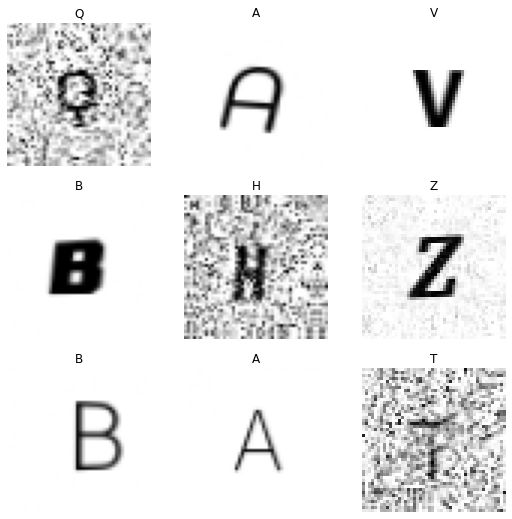

In [9]:
learn,learn_fn,best_fn = do_build_ocr_learner("v2b", # RERUN
                                              df=df_tmnist,
                                              split_at=CornetLayer.V2)

SuggestedLRs(minimum=0.06309573650360108, steep=0.0008317637839354575, valley=0.0010000000474974513, slide=0.0003981071640737355)

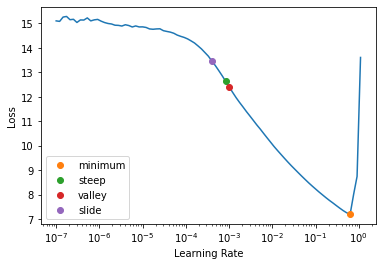

In [11]:
# learn.load(best_fn) # Continue after crash
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
lrs

In [12]:
lrs.valley

0.0010000000474974513

In [13]:
learn.fit_one_cycle(10, lrs.valley)
learn.save(f"{learn_fn}_ep10")

Better model found at epoch 0 with valid_loss value: 3.2615504264831543.
Better model found at epoch 1 with valid_loss value: 1.761860728263855.
Better model found at epoch 2 with valid_loss value: 0.8080404996871948.
Better model found at epoch 3 with valid_loss value: 0.5631637573242188.
Better model found at epoch 4 with valid_loss value: 0.4808293282985687.
Better model found at epoch 5 with valid_loss value: 0.4280050992965698.
Better model found at epoch 6 with valid_loss value: 0.4012964069843292.
Better model found at epoch 7 with valid_loss value: 0.3835352957248688.
Better model found at epoch 8 with valid_loss value: 0.37798431515693665.
Better model found at epoch 9 with valid_loss value: 0.3770526051521301.


Path('models/e2_cornet_z_v2b_ep10.pth')

The data for the first run was:

    epoch	train_loss	valid_loss	accuracy	time
    0	4.386069	3.904872	0.040083	07:13
    1	3.023575	2.442286	0.323809	06:50
    2	2.219517	1.092651	0.723969	07:18
    3	1.748566	0.672798	0.838664	07:06
    4	1.541304	0.518175	0.879350	06:50
    5	1.432263	0.460574	0.888852	06:52
    6	1.339652	0.418826	0.899157	06:51
    7	1.291803	0.406087	0.903172	06:50
    8	1.280678	0.399772	0.903640	06:51
    9	1.273137	0.397855	0.904309	06:50
    ...
    Better model found at epoch 9 with valid_loss value: 0.397855281829834.

In [14]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep10_best")
learn.fit_one_cycle(10, lrs.valley/10)
learn.save(f"{learn_fn}_ep20")

Better model found at epoch 0 with valid_loss value: 0.37587982416152954.
Better model found at epoch 1 with valid_loss value: 0.37489256262779236.
Better model found at epoch 2 with valid_loss value: 0.36845776438713074.
Better model found at epoch 3 with valid_loss value: 0.364834725856781.
Better model found at epoch 4 with valid_loss value: 0.36074939370155334.
Better model found at epoch 5 with valid_loss value: 0.3589756190776825.
Better model found at epoch 6 with valid_loss value: 0.3561517894268036.
Better model found at epoch 7 with valid_loss value: 0.3538481593132019.
Better model found at epoch 8 with valid_loss value: 0.3534833788871765.
Better model found at epoch 9 with valid_loss value: 0.3532133102416992.


Path('models/e2_cornet_z_v2b_ep20.pth')

The data for the earlier attempt was:

    epoch	train_loss	valid_loss	accuracy	time
    0	1.269895	0.397002	0.904979	06:50
    1	1.278704	0.394586	0.905046	06:51
    2	1.263513	0.388627	0.906317	06:52
    3	1.250632	0.383161	0.906250	06:51
    4	1.227207	0.380983	0.905915	06:51
    5	1.245057	0.376990	0.907321	06:51
    6	1.227202	0.374235	0.907588	06:51
    7	1.240655	0.372997	0.907923	06:51
    8	1.222107	0.372050	0.907588	06:51
    9	1.221140	0.372001	0.908057	06:52

It looks like, there's still room for improvement.

In [18]:
learn.load(best_fn)
learn.fit_one_cycle(10, 2e-4) # Let's try a bigger LR
learn.save(f"{learn_fn}_ep30")

Better model found at epoch 0 with valid_loss value: 0.3393353223800659.
Better model found at epoch 1 with valid_loss value: 0.33429762721061707.
Better model found at epoch 2 with valid_loss value: 0.332064151763916.
Better model found at epoch 3 with valid_loss value: 0.3275262415409088.
Better model found at epoch 4 with valid_loss value: 0.3222232758998871.
Better model found at epoch 5 with valid_loss value: 0.31812137365341187.
Better model found at epoch 6 with valid_loss value: 0.31576108932495117.
Better model found at epoch 7 with valid_loss value: 0.3151008188724518.
Better model found at epoch 8 with valid_loss value: 0.3131394684314728.
Better model found at epoch 9 with valid_loss value: 0.31297844648361206.


Path('models/e2_cornet_z_v2b_ep30.pth')

In [19]:
learn.fit_one_cycle(10, 5e-4) # Let's try a bigger LR
learn.save(f"{learn_fn}_ep40")

Better model found at epoch 0 with valid_loss value: 0.31373724341392517.
Better model found at epoch 2 with valid_loss value: 0.298976868391037.
Better model found at epoch 3 with valid_loss value: 0.29459959268569946.
Better model found at epoch 4 with valid_loss value: 0.28706690669059753.
Better model found at epoch 5 with valid_loss value: 0.28435325622558594.
Better model found at epoch 6 with valid_loss value: 0.28034257888793945.
Better model found at epoch 7 with valid_loss value: 0.27585190534591675.
Better model found at epoch 8 with valid_loss value: 0.2749079167842865.
Better model found at epoch 9 with valid_loss value: 0.27470022439956665.


Path('models/e2_cornet_z_v2b_ep40.pth')

In [20]:
learn.fit_one_cycle(20, 8e-4) # Let's try a bigger LR
learn.save(f"{learn_fn}_ep60")

Better model found at epoch 0 with valid_loss value: 0.27466800808906555.
Better model found at epoch 1 with valid_loss value: 0.2737422287464142.
Better model found at epoch 4 with valid_loss value: 0.26122918725013733.
Better model found at epoch 5 with valid_loss value: 0.2605287730693817.
Better model found at epoch 7 with valid_loss value: 0.2498926818370819.
Better model found at epoch 8 with valid_loss value: 0.2472705841064453.
Better model found at epoch 9 with valid_loss value: 0.2420148402452469.
Better model found at epoch 10 with valid_loss value: 0.23898300528526306.
Better model found at epoch 11 with valid_loss value: 0.23369485139846802.
Better model found at epoch 13 with valid_loss value: 0.23193630576133728.
Better model found at epoch 14 with valid_loss value: 0.2307153195142746.
Better model found at epoch 15 with valid_loss value: 0.22948557138442993.
Better model found at epoch 16 with valid_loss value: 0.22868217527866364.
Better model found at epoch 17 with va

Path('models/e2_cornet_z_v2b_ep60.pth')

In [21]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep60_best")

Path('models/e2_cornet_z_v2b_ep60_best.pth')

In [26]:
learn.load(best_fn)
learn.fit_one_cycle(20, 8e-4)
learn.save(f"{learn_fn}_ep80")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep80_best")

Better model found at epoch 0 with valid_loss value: 0.22292323410511017.
Better model found at epoch 6 with valid_loss value: 0.22029247879981995.
Better model found at epoch 7 with valid_loss value: 0.2169107347726822.
Better model found at epoch 10 with valid_loss value: 0.20994026958942413.
Better model found at epoch 11 with valid_loss value: 0.20864668488502502.
Better model found at epoch 12 with valid_loss value: 0.2076776921749115.
Better model found at epoch 13 with valid_loss value: 0.20610982179641724.
Better model found at epoch 14 with valid_loss value: 0.20570173859596252.
Better model found at epoch 15 with valid_loss value: 0.20367249846458435.
Better model found at epoch 17 with valid_loss value: 0.202332004904747.
Better model found at epoch 18 with valid_loss value: 0.20219001173973083.
Better model found at epoch 19 with valid_loss value: 0.20214644074440002.


Path('models/e2_cornet_z_v2b_ep80_best.pth')

In [27]:
learn.load(best_fn)
learn.fit_one_cycle(20, 8e-4)
learn.save(f"{learn_fn}_ep100")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep100_best")

Better model found at epoch 0 with valid_loss value: 0.201823890209198.
Better model found at epoch 5 with valid_loss value: 0.1987311840057373.
Better model found at epoch 10 with valid_loss value: 0.19575949013233185.
Better model found at epoch 11 with valid_loss value: 0.19394004344940186.
Better model found at epoch 12 with valid_loss value: 0.1910208761692047.
Better model found at epoch 13 with valid_loss value: 0.19003288447856903.
Better model found at epoch 14 with valid_loss value: 0.1881365180015564.
Better model found at epoch 17 with valid_loss value: 0.18715527653694153.
Better model found at epoch 18 with valid_loss value: 0.18693570792675018.


Path('models/e2_cornet_z_v2b_ep100_best.pth')

In [28]:
learn.load(best_fn)
learn.fit_one_cycle(20, 4e-4)
learn.save(f"{learn_fn}_ep120")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep120_best")

Better model found at epoch 0 with valid_loss value: 0.1881113350391388.
Better model found at epoch 1 with valid_loss value: 0.1867726445198059.
Better model found at epoch 7 with valid_loss value: 0.1863764077425003.
Better model found at epoch 9 with valid_loss value: 0.18623049557209015.
Better model found at epoch 10 with valid_loss value: 0.1856393814086914.
Better model found at epoch 11 with valid_loss value: 0.18304918706417084.
Better model found at epoch 12 with valid_loss value: 0.1826741248369217.
Better model found at epoch 13 with valid_loss value: 0.1817677915096283.
Better model found at epoch 15 with valid_loss value: 0.18119032680988312.
Better model found at epoch 17 with valid_loss value: 0.18068620562553406.
Better model found at epoch 19 with valid_loss value: 0.18056878447532654.


Path('models/e2_cornet_z_v2b_ep120_best.pth')

In [29]:
learn.load(best_fn)
learn.fit_one_cycle(20, 4e-4)
learn.save(f"{learn_fn}_ep140")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep140_best")

Better model found at epoch 0 with valid_loss value: 0.1803353875875473.
Better model found at epoch 7 with valid_loss value: 0.1790296733379364.
Better model found at epoch 8 with valid_loss value: 0.1766839474439621.
Better model found at epoch 10 with valid_loss value: 0.17656847834587097.
Better model found at epoch 12 with valid_loss value: 0.1760745644569397.
Better model found at epoch 13 with valid_loss value: 0.17591752111911774.
Better model found at epoch 15 with valid_loss value: 0.1756429225206375.
Better model found at epoch 16 with valid_loss value: 0.1748269498348236.


Path('models/e2_cornet_z_v2b_ep140_best.pth')

Best valid loss until ep 140: 0.1748269498348236.

In [10]:
learn.load(f"{learn_fn}_ep140_best")
learn.fit_one_cycle(20, 4e-4)
learn.save(f"{learn_fn}_ep160")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep160_best")

Better model found at epoch 0 with valid_loss value: 0.17504583299160004.
Better model found at epoch 18 with valid_loss value: 0.1749146431684494.
Better model found at epoch 19 with valid_loss value: 0.17479507625102997.


Path('models/e2_cornet_z_v2b_ep160_best.pth')

> It seems valid loss of 0.17479507625102997 at ep 160 is about as low as we can get. We'll save it as `e2_cornet_z_v2_final.pth`.

### Train Version 3: V4–Decoder, Fonts and Handwritten, Basic Gaussian Noise – `e2_cornet_z_v3_final.pth`

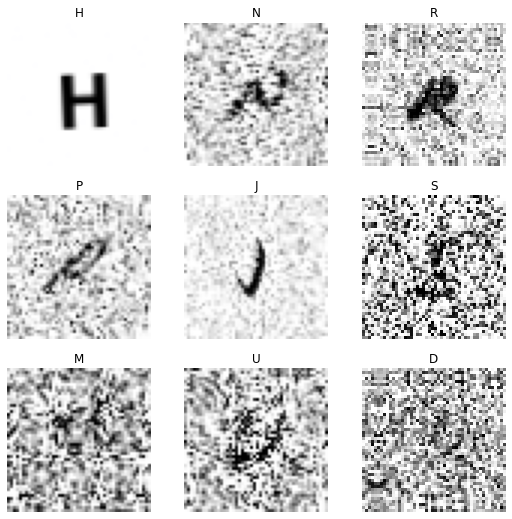

In [30]:
learn,learn_fn,best_fn = do_build_ocr_learner("v3", 
                                              df=df_az_and_tmnist,
                                              split_at=CornetLayer.V4)

SuggestedLRs(minimum=0.06309573650360108, steep=0.0005754399462603033, valley=0.0010000000474974513, slide=0.0003311311302240938)

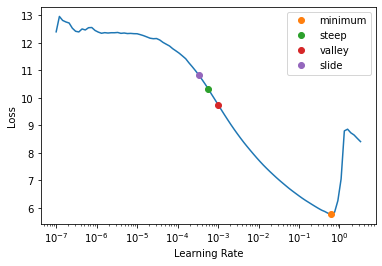

In [117]:
# learn.load(best_fn) # Continue after crash
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
lrs

In [118]:
lrs.valley

0.0010000000474974513

In [119]:
learn.fit_one_cycle(10, lrs.valley)
learn.save(f"{learn_fn}_ep10")

Better model found at epoch 0 with valid_loss value: 0.21978659927845.
Better model found at epoch 1 with valid_loss value: 0.15138551592826843.
Better model found at epoch 2 with valid_loss value: 0.11396533995866776.
Better model found at epoch 3 with valid_loss value: 0.09178221970796585.
Better model found at epoch 5 with valid_loss value: 0.08368398994207382.
Better model found at epoch 7 with valid_loss value: 0.06567037850618362.
Better model found at epoch 8 with valid_loss value: 0.06289004534482956.
Better model found at epoch 9 with valid_loss value: 0.06193815916776657.


Path('models/e2_cornet_z_v3_ep10.pth')

In [120]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep10_best")
learn.fit_one_cycle(10, lrs.valley/10)
learn.save(f"{learn_fn}_ep20")

Better model found at epoch 0 with valid_loss value: 0.062215305864810944.
Better model found at epoch 3 with valid_loss value: 0.06139020994305611.
Better model found at epoch 5 with valid_loss value: 0.06058960407972336.
Better model found at epoch 6 with valid_loss value: 0.05978216975927353.
Better model found at epoch 7 with valid_loss value: 0.058999501168727875.
Better model found at epoch 8 with valid_loss value: 0.05884729325771332.


Path('models/e2_cornet_z_v3_ep20.pth')

In [31]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep20_best")
learn.fit_one_cycle(20, 5e-5)
learn.save(f"{learn_fn}_ep40")

Better model found at epoch 0 with valid_loss value: 0.04895279183983803.
Better model found at epoch 13 with valid_loss value: 0.048635099083185196.
Better model found at epoch 16 with valid_loss value: 0.04850287362933159.


> It seems valid loss of 0.04850287362933159 at ep 37 is about as low as we can get. We'll save it as `e2_cornet_z_v3_final.pth`.

### Train Version 4: V2–Decoder, Fonts and Handwritten, Basic Gaussian Noise – `e2_cornet_z_v4_final.pth`

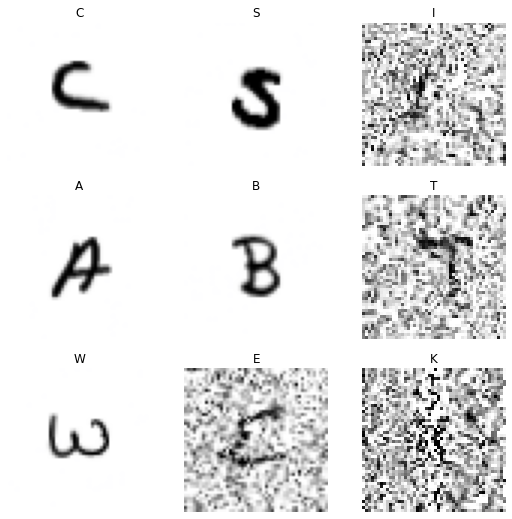

In [11]:
learn,learn_fn,best_fn = do_build_ocr_learner("v4", 
                                              df=df_az_and_tmnist,
                                              split_at=CornetLayer.V2)

SuggestedLRs(minimum=0.03630780577659607, steep=0.0008317637839354575, valley=0.0012022644514217973, slide=0.0005754399462603033)

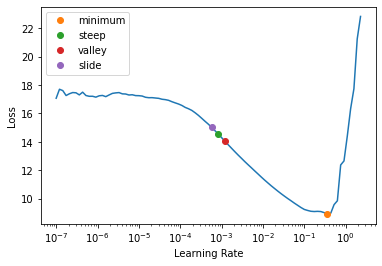

In [122]:
# learn.load(best_fn) # Continue after crash
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
lrs

In [123]:
lrs.valley

0.0012022644514217973

In [124]:
learn.fit_one_cycle(10, lrs.valley)
learn.save(f"{learn_fn}_ep10")

Better model found at epoch 0 with valid_loss value: 1.0553431510925293.
Better model found at epoch 1 with valid_loss value: 0.4400086998939514.
Better model found at epoch 2 with valid_loss value: 0.31893542408943176.
Better model found at epoch 3 with valid_loss value: 0.26285773515701294.
Better model found at epoch 4 with valid_loss value: 0.22852590680122375.
Better model found at epoch 5 with valid_loss value: 0.22000752389431.
Better model found at epoch 6 with valid_loss value: 0.20302735269069672.
Better model found at epoch 7 with valid_loss value: 0.1955394446849823.
Better model found at epoch 8 with valid_loss value: 0.19235916435718536.
Better model found at epoch 9 with valid_loss value: 0.19102896749973297.


Path('models/e2_cornet_z_v4_ep10.pth')

In [9]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep10_best")
learn.fit_one_cycle(6, 1e-3) # 10, lrs.valley/10) # Crash after 4 epochs
learn.save(f"{learn_fn}_ep20")

Better model found at epoch 0 with valid_loss value: 0.20225007832050323.
Better model found at epoch 2 with valid_loss value: 0.19282543659210205.
Better model found at epoch 3 with valid_loss value: 0.18520013988018036.
Better model found at epoch 4 with valid_loss value: 0.1763712763786316.
Better model found at epoch 5 with valid_loss value: 0.17442883551120758.


Path('models/e2_cornet_z_v4_ep20.pth')

In [23]:
learn.load(best_fn)
learn.fit_one_cycle(30, .5e-3)
learn.save(f"{learn_fn}_ep50")

Better model found at epoch 0 with valid_loss value: 0.17051897943019867.
Better model found at epoch 5 with valid_loss value: 0.16954828798770905.
Better model found at epoch 7 with valid_loss value: 0.1677347719669342.
Better model found at epoch 9 with valid_loss value: 0.16593706607818604.
Better model found at epoch 11 with valid_loss value: 0.16202005743980408.
Better model found at epoch 14 with valid_loss value: 0.15632398426532745.
Better model found at epoch 19 with valid_loss value: 0.15620382130146027.
Better model found at epoch 20 with valid_loss value: 0.15304546058177948.
Better model found at epoch 21 with valid_loss value: 0.15077424049377441.
Better model found at epoch 23 with valid_loss value: 0.15021169185638428.
Better model found at epoch 24 with valid_loss value: 0.1498095989227295.
Better model found at epoch 26 with valid_loss value: 0.14946593344211578.
Better model found at epoch 27 with valid_loss value: 0.1489105522632599.


Path('models/e2_cornet_z_v4_ep50.pth')

In [24]:
learn.load(best_fn)
learn.save(f"{learn_fn}_ep50_best")
learn.fit_one_cycle(10, .25e-3)
learn.save(f"{learn_fn}_ep60")

Better model found at epoch 0 with valid_loss value: 0.15070681273937225.
Better model found at epoch 4 with valid_loss value: 0.15068107843399048.
Better model found at epoch 5 with valid_loss value: 0.14854945242404938.
Better model found at epoch 7 with valid_loss value: 0.14801788330078125.
Better model found at epoch 8 with valid_loss value: 0.14755478501319885.
Better model found at epoch 9 with valid_loss value: 0.14731691777706146.


Path('models/e2_cornet_z_v4_ep60.pth')

Best valid loss until up to ep 60: 0.14731691777706146.

In [12]:
learn.load(f"{learn_fn}_ep60")
learn.fit_one_cycle(40, .5e-3)
learn.save(f"{learn_fn}_ep100")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep100_best")


Better model found at epoch 0 with valid_loss value: 0.14611110091209412.
Better model found at epoch 20 with valid_loss value: 0.14463719725608826.
Better model found at epoch 22 with valid_loss value: 0.14133894443511963.
Better model found at epoch 25 with valid_loss value: 0.14065882563591003.
Better model found at epoch 27 with valid_loss value: 0.1396828293800354.
Better model found at epoch 28 with valid_loss value: 0.13824598491191864.
Better model found at epoch 31 with valid_loss value: 0.13776275515556335.
Better model found at epoch 32 with valid_loss value: 0.13699397444725037.
Better model found at epoch 34 with valid_loss value: 0.13691651821136475.
Better model found at epoch 35 with valid_loss value: 0.13689111173152924.
Better model found at epoch 36 with valid_loss value: 0.13612684607505798.
Better model found at epoch 38 with valid_loss value: 0.13609646260738373.
Better model found at epoch 39 with valid_loss value: 0.13607683777809143.


Path('models/e2_cornet_z_v4_ep100_best.pth')

In [26]:
learn.load(best_fn)
learn.fit_one_cycle(20, .5e-5)
learn.save(f"{learn_fn}_ep120")
learn.load(best_fn)
learn.save(f"{learn_fn}_ep120_best")

Better model found at epoch 0 with valid_loss value: 0.13607259094715118.
Better model found at epoch 1 with valid_loss value: 0.135990172624588.
Better model found at epoch 3 with valid_loss value: 0.1359841227531433.
Better model found at epoch 9 with valid_loss value: 0.13595066964626312.
Better model found at epoch 10 with valid_loss value: 0.13592109084129333.
Better model found at epoch 12 with valid_loss value: 0.13588835299015045.
Better model found at epoch 13 with valid_loss value: 0.1358596235513687.
Better model found at epoch 14 with valid_loss value: 0.13580204546451569.


Path('models/e2_cornet_z_v4_ep120_best.pth')

> It seems valid loss of 0.13580204546451569 at ep 115 is about as low as we can get. We'll save it as `e2_cornet_z_v4_final.pth`.

### Results and Statistics

| Version | Trained layers | Dataset | Initial max LR | Accuracy | Model path | Training sessions | Final epoch |
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | 
| v1 | V4–decoder | Fonts only | 2.1e-3 | 0.982 | e2_cornet_z_v1_final.pth | 10@2e-3, 10@2e-4, 20@1e-4 | 21 |
| v2(b) | V2–decoder | Fonts only | 1.0e-3 | 0.959 | e2_cornet_z_v2_final.pth | 10@1e-3, 10@1e-4, 10@2e-4, 10@5e-4, 20@8e-4, 20@8e-4, 20@8e-4, 20@4e-4, 20@4e-4, 20@4e-4 | 160 |
| v3 | V4–decoder | Fonts and handwritten | 1.0e-3 | 0.988 | e2_cornet_z_v3_final.pth | 10@1e-3, 10@1e-4, 20@5e-5 | 37 |
| v4 | V2–decoder | Fonts and handwritten | 1.2e-3 | 0.965 | e2_cornet_z_v4_final.pth | 10@1.2e-3, 10@1e-3, 30@5e-4, 10@2.5e-4, 40@5e-4, 20@5e-6 | 115 |

All models were initally trained for 10 epochs with the initital max LR and then for another 10 with 1/10. They were then trained with variable learning rates and epochs until convergence. The best epoch in a training session was always selected as the starting point for the next session.

It's quite curious that the accuracy of both of the models in which V2 is trained, is lower than the ones where only layers from V4 onwards were trained. It might be possible that this is due only to suboptimal training details, such as too high initial learning rate.

#### Calculations

Recalculate accuracies.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


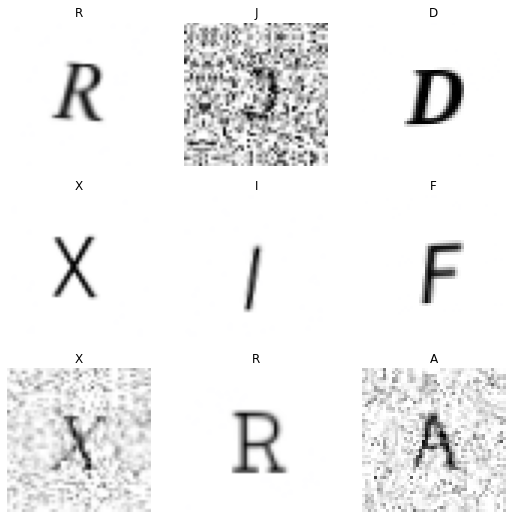

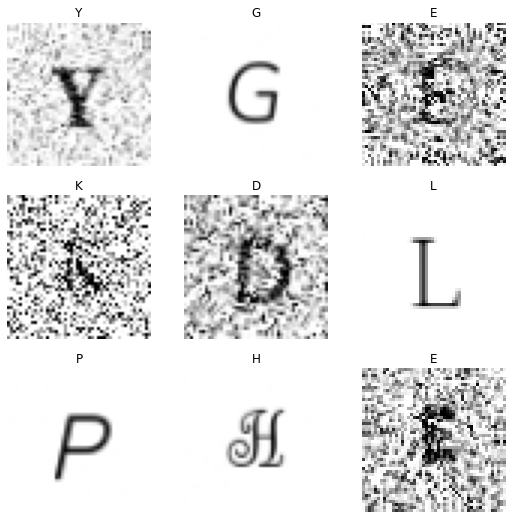

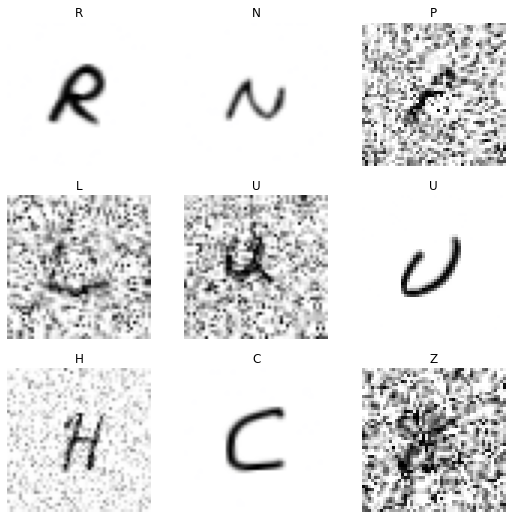

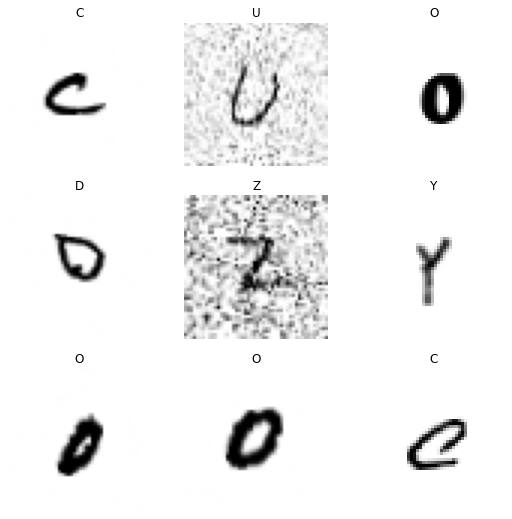

In [7]:
accs = {}
for v,df in zip(["v1", "v2", "v3", "v4"], [df_tmnist, df_tmnist, df_az_and_tmnist, df_az_and_tmnist]):
    learn,learn_fn,best_fn = do_build_ocr_learner(v, df=df, split_at=CornetLayer.V2, save_cb=False) # The split doesn't matter
    final_fn = f"{learn_fn}_final"
    learn.load(final_fn)
    accs[v] = learn.validate()

In [8]:
accs

{'v1': (#2) [0.0723867267370224,0.9819994568824768],
 'v2': (#2) [0.160721093416214,0.9586455821990967],
 'v3': (#2) [0.04500362277030945,0.9881476759910583],
 'v4': (#2) [0.1348223090171814,0.9651362895965576]}

## Step 2: Fine-Tune to Match Human Confusion Matrix Data

> Dubbed 'empirical alignment' in the thesis text.

### Define Font dataset

In [5]:
arial_df      = get_font_df([SYS_FONT_PATH/"Arial.ttf"])
sans_serif_df = get_sans_serif_df()
print(f"Fonts in sans serif dataset: {len(sans_serif_df)/len(VOCAB_UC)}")

Fonts in sans serif dataset: 250.0


### Find a Noise Level for 50% Accuracy 

Accuracy as measured by correct classification probability.

#### Define variables and utility functions

In [6]:
base_tfms = dict(use_affine_tfms=False,
                 use_xtra_tfms=True,
                 tfms_p=1.,
                 blur_size=None,
                 blur_sigma=None,
                 noise_f=None,
                 noise_method=BlendingMethod.ADD,
                 noise_type=NoiseType.GAUSSIAN,
                 size=48,
                 normalize=True,
                 translate_and_pad=0.
                 )

def do_find_tfms_for_accuracy(
    df: DataFrame,
    ocr_fn = BASE_OCR_MODEL_FN,
    init_noise_f = .3,
    bs=26,
) -> tuple[Learner, dict]:
    """Local utility wrapper for `find_tfms_for_accuracy`."""
    gc.collect()
    ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)  
    learn,tfms = find_tfms_for_accuracy(
        ocr_model, 
        df=df, 
        target_acc=None, 
        target_prob=.5,
        param="noise_f",
        param_start=init_noise_f,
        param_step=.3, 
        base_tfms=base_tfms, 
        bs=bs, 
        max_iters=30,
        )
    return learn,tfms

In [29]:
def do_cm_comparison(
    ocr_fn: str,
    tfms: dict,
    iters = 1,
) -> DataFrame:
    """Quickly compare an OCR model's confusion matrix to the human one."""
    cm_ocr = get_confusion_matrix(ocr_fn, tfms=tfms, iters=iters)
    cm_emp = get_empirical_confusion_matrix(CM_VD_HEIJDEN_PATH)
    return compare_confusion_matrices(cm_emp, cm_ocr, symmetrize=True, non_diagonal=True)

def do_cm_comparison_for_versions(
    versions = ["v1", "v2", "v3", "v4"],
    base_fn = "e2_cornet_z_",
    fn_suffix = "_final.pth",
    iters = 10,
) -> DataFrame:
    """Compare the Pearson Rs to the empirical matrix of different OCR models"""
    res = None
    for v in versions:
        learn_fn  = f"{base_fn}{v}"
        best_fn   = f"{learn_fn}{fn_suffix}"
        init_r = do_cm_comparison(best_fn, BASE_TFMS, iters=iters)
        _,tfms = do_find_tfms_for_accuracy(df=arial_df, ocr_fn=best_fn)
        degr_r = do_cm_comparison(best_fn, tfms, iters=10)
        z = DataFrame([["a",0,1],["b",0,1]])
        init_r.columns = [f"{o} {v} Initial"  for o in init_r.columns]
        degr_r.columns = [f"{o} {v} Degraded" for o in degr_r.columns]
        if res is None: res = pd.concat((     init_r, degr_r), axis=1)
        else:           res = pd.concat((res, init_r, degr_r), axis=1)
    return res

def plot_cm_comparisons(
    df: DataFrame,
    figsize = (12,6),
    dpi = 144,
    incl_prefix = "Pearson",
    incl_suffix: str = None,
) -> None:
    """Plot the Pearson Rs returned by `do_cm_comparison_for_versions`"""
    fig = plt.figure(figsize=figsize, dpi=dpi)
    df = df.drop([o for o in df.columns if not o.startswith(incl_prefix)], axis=1)
    if incl_suffix is not None: df = df.drop([o for o in df.columns if not o.endswith(incl_suffix)], axis=1)
    df.plot(ax=plt.gca())
    plt.xticks(np.arange(len(df)), df.index)
    plt.legend(loc="lower right")

#### Compare OCR model versions' CM correlations before finetuning

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 0.3 • Step 0.3 • Accuracy 0.9998


Iter 1 • Param (noise_f): 0.6 • Step 0.3 • Accuracy 0.9840


Iter 2 • Param (noise_f): 0.8999999999999999 • Step 0.3 • Accuracy 0.9548


Iter 3 • Param (noise_f): 1.2 • Step 0.3 • Accuracy 0.8561


Iter 4 • Param (noise_f): 1.5 • Step 0.3 • Accuracy 0.6192


Iter 5 • Param (noise_f): 1.8 • Step 0.3 • Accuracy 0.3351


Iter 6 • Param (noise_f): 1.6500000000000001 • Step -0.15 • Accuracy 0.5609


Iter 7 • Param (noise_f): 1.725 • Step 0.075 • Accuracy 0.4792


Iter 8 • Param (noise_f): 1.6875 • Step -0.0375 • Accuracy 0.4506


Iter 9 • Param (noise_f): 1.65 • Step -0.0375 • Accuracy 0.6117


Iter 10 • Param (noise_f): 1.66875 • Step 0.01875 • Accuracy 0.5018
Final accuracy per letter
A: 0.143
B: 0.069
C: 0.585
D: 0.974
E: 0.649
F: 0.020
G: 0.230
H: 0.914
I: 0.347
J: 0.115
K: 0.983
L: 0.589
M: 0.652
N: 0.905
O: 0.588
P: 0.685
Q: 0.023
R: 0.449
S: 0.179
T: 0.501
U: 0.970
V: 0.250
W: 0.307
X: 0.105
Y: 0.842
Z: 0.973


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 0.3 • Step 0.3 • Accuracy 0.9464


Iter 1 • Param (noise_f): 0.6 • Step 0.3 • Accuracy 0.8867


Iter 2 • Param (noise_f): 0.8999999999999999 • Step 0.3 • Accuracy 0.7936


Iter 3 • Param (noise_f): 1.2 • Step 0.3 • Accuracy 0.6141


Iter 4 • Param (noise_f): 1.5 • Step 0.3 • Accuracy 0.3837


Iter 5 • Param (noise_f): 1.35 • Step -0.15 • Accuracy 0.5099
Final accuracy per letter
A: 0.682
B: 0.982
C: 0.031
D: 0.059
E: 0.463
F: 0.002
G: 0.739
H: 0.991
I: 0.087
J: 0.161
K: 0.833
L: 0.138
M: 0.145
N: 0.859
O: 0.516
P: 0.059
Q: 0.331
R: 0.832
S: 0.413
T: 0.377
U: 0.954
V: 0.677
W: 0.027
X: 0.947
Y: 0.952
Z: 0.999


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 0.3 • Step 0.3 • Accuracy 0.9997


Iter 1 • Param (noise_f): 0.6 • Step 0.3 • Accuracy 0.9973


Iter 2 • Param (noise_f): 0.8999999999999999 • Step 0.3 • Accuracy 0.8856


Iter 3 • Param (noise_f): 1.2 • Step 0.3 • Accuracy 0.8637


Iter 4 • Param (noise_f): 1.5 • Step 0.3 • Accuracy 0.6070


Iter 5 • Param (noise_f): 1.8 • Step 0.3 • Accuracy 0.4231


Iter 6 • Param (noise_f): 1.6500000000000001 • Step -0.15 • Accuracy 0.5845


Iter 7 • Param (noise_f): 1.725 • Step 0.075 • Accuracy 0.4189


Iter 8 • Param (noise_f): 1.6875 • Step -0.0375 • Accuracy 0.4125


Iter 9 • Param (noise_f): 1.65 • Step -0.0375 • Accuracy 0.5748


Iter 10 • Param (noise_f): 1.66875 • Step 0.01875 • Accuracy 0.4617


Iter 11 • Param (noise_f): 1.659375 • Step -0.009375 • Accuracy 0.4728


Iter 12 • Param (noise_f): 1.6500000000000001 • Step -0.009375 • Accuracy 0.5156


Iter 13 • Param (noise_f): 1.6546875 • Step 0.0046875 • Accuracy 0.4607


Iter 14 • Param (noise_f): 1.65234375 • Step -0.00234375 • Accuracy 0.4839


Iter 15 • Param (noise_f): 1.65 • Step -0.00234375 • Accuracy 0.4491


Iter 16 • Param (noise_f): 1.6476562499999998 • Step -0.00234375 • Accuracy 0.4753


Iter 17 • Param (noise_f): 1.6453124999999997 • Step -0.00234375 • Accuracy 0.5420


Iter 18 • Param (noise_f): 1.6464843749999998 • Step 0.001171875 • Accuracy 0.4382


Iter 19 • Param (noise_f): 1.6458984374999999 • Step -0.0005859375 • Accuracy 0.4803


Iter 20 • Param (noise_f): 1.6453125 • Step -0.0005859375 • Accuracy 0.5608


Iter 21 • Param (noise_f): 1.64560546875 • Step 0.00029296875 • Accuracy 0.5028
Final accuracy per letter
A: 0.747
B: 0.411
C: 0.958
D: 0.084
E: 0.977
F: 0.110
G: 0.003
H: 0.637
I: 0.040
J: 0.865
K: 0.884
L: 0.833
M: 0.008
N: 0.174
O: 0.686
P: 0.133
Q: 0.123
R: 0.553
S: 0.998
T: 0.223
U: 0.963
V: 0.975
W: 0.113
X: 0.972
Y: 0.427
Z: 0.178


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 0.3 • Step 0.3 • Accuracy 0.9647


Iter 1 • Param (noise_f): 0.6 • Step 0.3 • Accuracy 0.9217


Iter 2 • Param (noise_f): 0.8999999999999999 • Step 0.3 • Accuracy 0.8267


Iter 3 • Param (noise_f): 1.2 • Step 0.3 • Accuracy 0.6212


Iter 4 • Param (noise_f): 1.5 • Step 0.3 • Accuracy 0.4363


Iter 5 • Param (noise_f): 1.35 • Step -0.15 • Accuracy 0.4452


Iter 6 • Param (noise_f): 1.2000000000000002 • Step -0.15 • Accuracy 0.5762


Iter 7 • Param (noise_f): 1.2750000000000001 • Step 0.075 • Accuracy 0.5839


Iter 8 • Param (noise_f): 1.35 • Step 0.075 • Accuracy 0.4630


Iter 9 • Param (noise_f): 1.3125 • Step -0.0375 • Accuracy 0.5817


Iter 10 • Param (noise_f): 1.33125 • Step 0.01875 • Accuracy 0.5719


Iter 11 • Param (noise_f): 1.35 • Step 0.01875 • Accuracy 0.4410


Iter 12 • Param (noise_f): 1.3406250000000002 • Step -0.009375 • Accuracy 0.4570


Iter 13 • Param (noise_f): 1.3312500000000003 • Step -0.009375 • Accuracy 0.4424


Iter 14 • Param (noise_f): 1.3218750000000004 • Step -0.009375 • Accuracy 0.5365


Iter 15 • Param (noise_f): 1.3265625000000003 • Step 0.0046875 • Accuracy 0.5203


Iter 16 • Param (noise_f): 1.3312500000000003 • Step 0.0046875 • Accuracy 0.5836


Iter 17 • Param (noise_f): 1.3359375000000002 • Step 0.0046875 • Accuracy 0.5051
Final accuracy per letter
A: 0.451
B: 0.369
C: 0.413
D: 0.062
E: 0.656
F: 0.038
G: 0.032
H: 0.894
I: 0.021
J: 0.074
K: 0.877
L: 0.769
M: 0.610
N: 0.201
O: 0.907
P: 0.311
Q: 0.154
R: 0.789
S: 0.998
T: 0.677
U: 0.845
V: 0.124
W: 0.197
X: 0.983
Y: 0.973
Z: 0.711


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


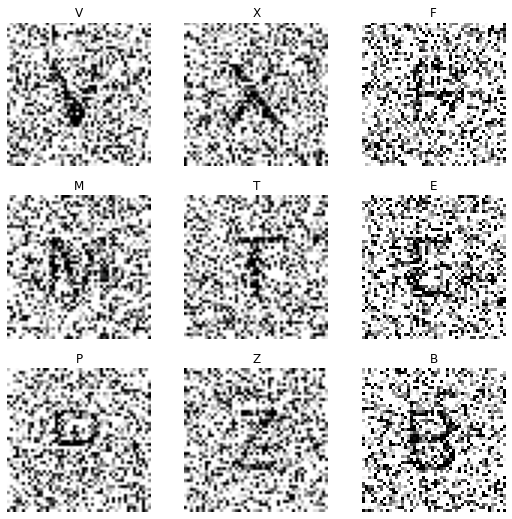

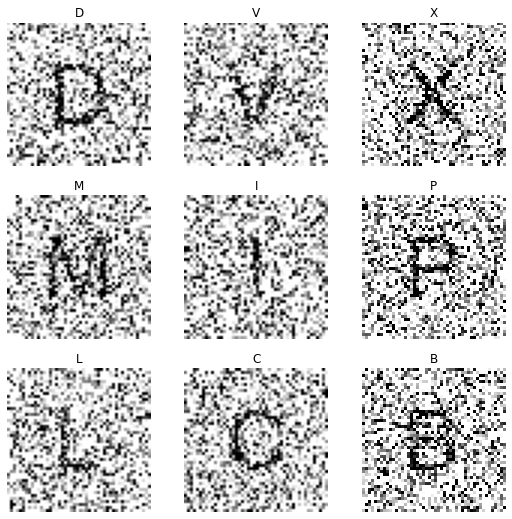

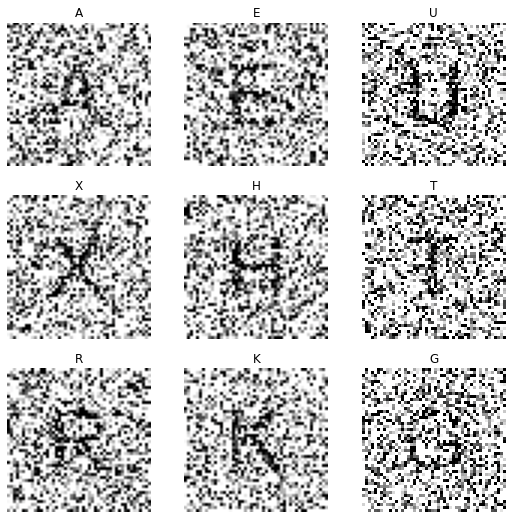

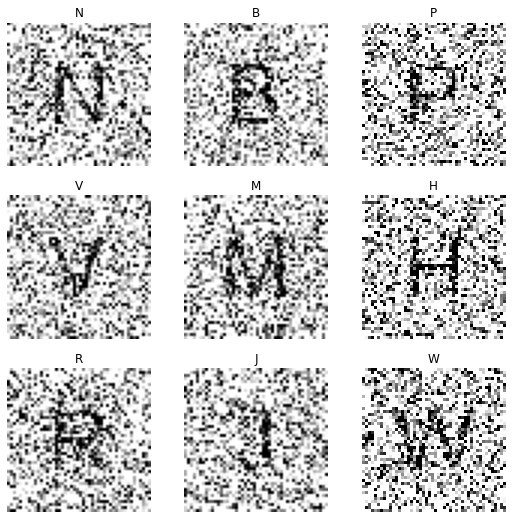

In [8]:
version_rs = do_cm_comparison_for_versions(["v1", "v2", "v3", "v4"])
dump(version_rs, DUMP_FOLDER / "ocr_model_correlations_with_vdh_before_finetuning.pkl")

The noise levels for Arial at 50% accuracy are:

    v1 1.66875
    v2 1.35
    v3 1.64560546875
    v4 1.3359375000000002

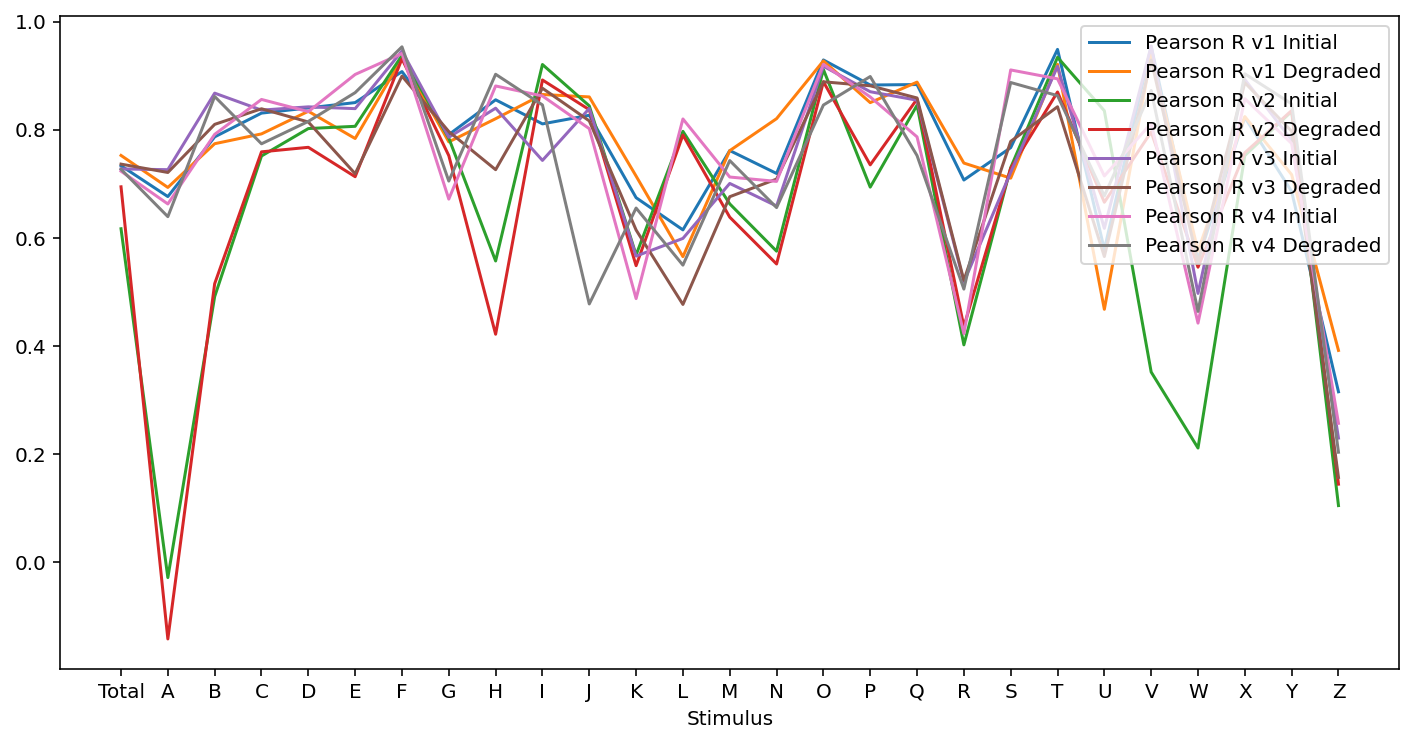

In [9]:
plot_cm_comparisons(version_rs)

In [17]:
for c,v in zip(version_rs.columns, version_rs.loc["Total"]): print(f"{c:<25} {v}")

Pearson R v1 Initial      0.7337618526964621
p v1 Initial              3.6162210282530114e-56
Pearson R v1 Degraded     0.7528166237050146
p v1 Degraded             1.274530767277531e-60
Pearson R v2 Initial      0.6171098606490718
p v2 Initial              1.7076843464230694e-35
Pearson R v2 Degraded     0.6947305922174859
p v2 Degraded             3.800790001456579e-48
Pearson R v3 Initial      0.7278371710791738
p v3 Initial              7.33410793438148e-55
Pearson R v3 Degraded     0.7367388432105053
p v3 Degraded             7.729671518653994e-57
Pearson R v4 Initial      0.7236327788118241
p v4 Initial              5.918045327191361e-54
Pearson R v4 Degraded     0.7271984159862683
p v4 Degraded             1.0097404559296697e-54


> The correlations are remarkably high even before finetuning. Testolin et al.'s (2017) model had a 0.66 correlation with Van der Heijden (1982) and an average to the empirical studies of 0.56. The notable exception is `v2`, but even that correlates much better when degraded to 50% accuracy.

#### Search for noise level with the full sans serif dataset

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 1.0 • Step 0.3 • Accuracy 0.7938


Iter 1 • Param (noise_f): 1.3 • Step 0.3 • Accuracy 0.6023


Iter 2 • Param (noise_f): 1.6 • Step 0.3 • Accuracy 0.4054


Iter 3 • Param (noise_f): 1.4500000000000002 • Step -0.15 • Accuracy 0.4983
Final accuracy per letter
A: 0.635
B: 0.431
C: 0.538
D: 0.535
E: 0.588
F: 0.337
G: 0.515
H: 0.616
I: 0.364
J: 0.324
K: 0.509
L: 0.365
M: 0.610
N: 0.543
O: 0.548
P: 0.391
Q: 0.239
R: 0.425
S: 0.671
T: 0.349
U: 0.529
V: 0.526
W: 0.371
X: 0.691
Y: 0.558
Z: 0.749


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 1.0 • Step 0.3 • Accuracy 0.7027


Iter 1 • Param (noise_f): 1.3 • Step 0.3 • Accuracy 0.5016
Final accuracy per letter
A: 0.464
B: 0.629
C: 0.450
D: 0.476
E: 0.555
F: 0.281
G: 0.523
H: 0.609
I: 0.293
J: 0.336
K: 0.521
L: 0.408
M: 0.552
N: 0.679
O: 0.448
P: 0.394
Q: 0.281
R: 0.451
S: 0.732
T: 0.434
U: 0.640
V: 0.514
W: 0.438
X: 0.582
Y: 0.572
Z: 0.779


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 1.0 • Step 0.3 • Accuracy 0.8044


Iter 1 • Param (noise_f): 1.3 • Step 0.3 • Accuracy 0.6177


Iter 2 • Param (noise_f): 1.6 • Step 0.3 • Accuracy 0.4239


Iter 3 • Param (noise_f): 1.4500000000000002 • Step -0.15 • Accuracy 0.5163


Iter 4 • Param (noise_f): 1.5250000000000001 • Step 0.075 • Accuracy 0.4670


Iter 5 • Param (noise_f): 1.4875 • Step -0.0375 • Accuracy 0.4932
Final accuracy per letter
A: 0.538
B: 0.488
C: 0.581
D: 0.409
E: 0.535
F: 0.144
G: 0.349
H: 0.564
I: 0.229
J: 0.380
K: 0.455
L: 0.672
M: 0.434
N: 0.534
O: 0.542
P: 0.613
Q: 0.175
R: 0.364
S: 0.835
T: 0.560
U: 0.613
V: 0.508
W: 0.433
X: 0.696
Y: 0.632
Z: 0.544


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Iter 0 • Param (noise_f): 1.0 • Step 0.3 • Accuracy 0.6431


Iter 1 • Param (noise_f): 1.3 • Step 0.3 • Accuracy 0.4500


Iter 2 • Param (noise_f): 1.1500000000000001 • Step -0.15 • Accuracy 0.5495


Iter 3 • Param (noise_f): 1.225 • Step 0.075 • Accuracy 0.4966
Final accuracy per letter
A: 0.519
B: 0.542
C: 0.648
D: 0.495
E: 0.632
F: 0.079
G: 0.312
H: 0.517
I: 0.108
J: 0.177
K: 0.502
L: 0.546
M: 0.584
N: 0.665
O: 0.524
P: 0.643
Q: 0.077
R: 0.366
S: 0.862
T: 0.661
U: 0.614
V: 0.334
W: 0.476
X: 0.757
Y: 0.573
Z: 0.700


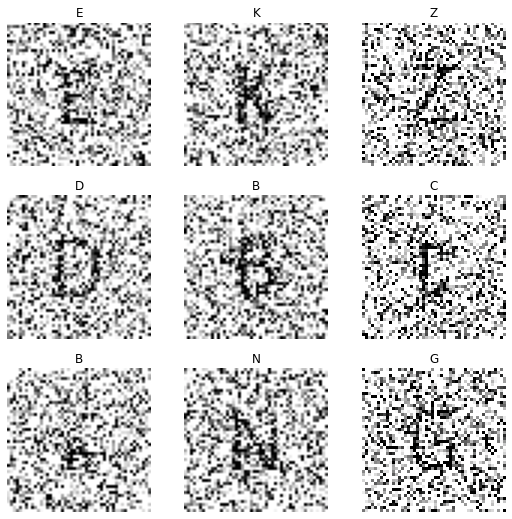

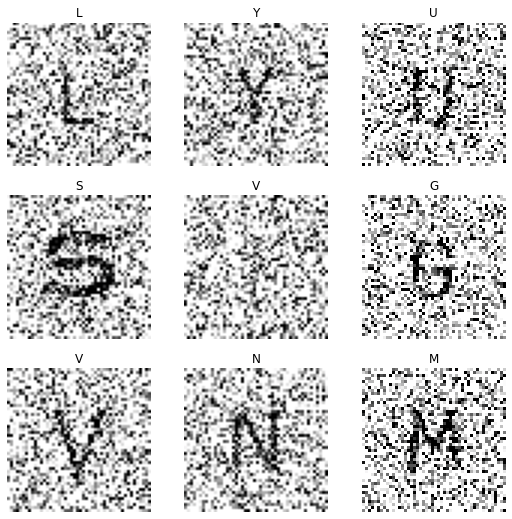

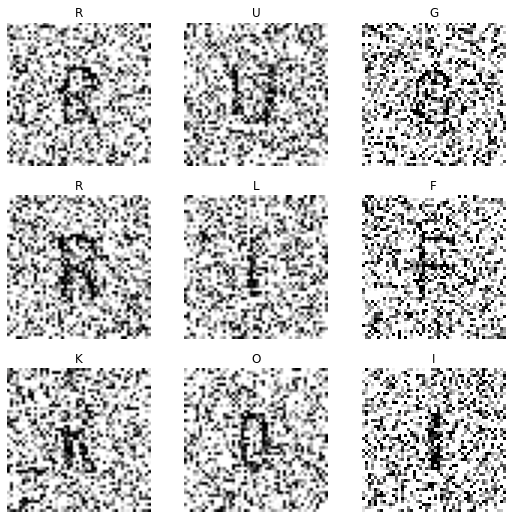

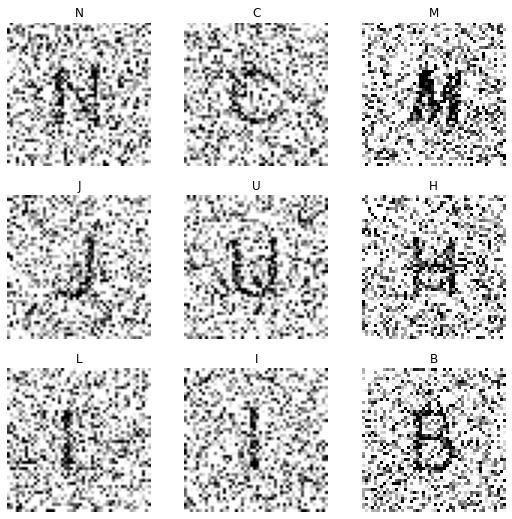

In [21]:
versions = ["v1", "v2", "v3", "v4"]
base_fn = "e2_cornet_z_"
acc_50_tfms = {}
for v in versions:
    ocr_fn = f"{base_fn}{v}_final.pth"
    learn,tfms = do_find_tfms_for_accuracy(df=sans_serif_df, ocr_fn=ocr_fn, init_noise_f=1.) # Was 1.6/1.44375 for Arial
    acc_50_tfms[v] = tfms

In [22]:
for v,tfms in acc_50_tfms.items():
    print(v, tfms["noise_f"])

v1 1.4500000000000002
v2 1.3
v3 1.4875
v4 1.225


Let's just take an average of the noise levels and use that.

> Note that these are multipliers to torch.randn() * .5. I.e. to get the noise variances they represent, divide by 2.

In [27]:
ACC_50_TFMS = {**acc_50_tfms[versions[0]]}
ACC_50_TFMS["noise_f"] = mean([o["noise_f"] for o in acc_50_tfms.values()])
ACC_50_TFMS # We'll move a copy of these values to §Common Variables

{'use_affine_tfms': False,
 'use_xtra_tfms': True,
 'tfms_p': 1.0,
 'blur_size': None,
 'blur_sigma': None,
 'noise_f': 1.365625,
 'noise_type': <NoiseType.GAUSSIAN: 2>,
 'noise_method': <BlendingMethod.ADD: 2>,
 'size': 48,
 'normalize': True,
 'translate_and_pad': 0.0}

### Finetune Output Probabilities to Match Confusion Matrix Distributions 

#### Define variables and functions

In [20]:
versions = ["v1", "v2", "v3", "v4"]

def do_build_finetuning_learner(
    version: str,
    df: DataFrame = sans_serif_df,
    split_at = CornetLayer.decoder,
    tfm_args = ACC_50_TFMS,
    save_cb = True,
    base_fn = "e2_cornet_z_",
    pretrained_suffix = "_final",
    learn_suffix = "_finetuned",
) -> tuple[Learner,str,str]:
    gc.collect()
    version_fn = f"{base_fn}{version}"
    model_fn = f"{version_fn}{pretrained_suffix}.pth"
    model = load_ocr_model(file=model_fn, arch=cornet_for_ocr, n_out=26)
    emp_cm = get_empirical_confusion_matrix()
    y_block = partial(CategoryDistibutionBlock, confusion_matrix=emp_cm, vocab=VOCAB_UC)
    base_args = dict(model=model, 
                     splitter=partial(cornet_splitter, split_at=split_at),
                     df=df,
                     y_block=y_block,
                     loss_func=CrossEntropyLossFlat(flatten=False),
                     metrics=None, # Otherwise accuracy calculation will raise bc of y_block
                     )
    learn_fn  = f"{version_fn}{learn_suffix}"
    best_fn   = f"{learn_fn}_best"
    cbs = [SaveModelCallback(fname=best_fn, with_opt=True)] if save_cb else None
    learn = build_ocr_learner(**base_args,
                              **tfm_args,
                                cbs=cbs,
                                bs=256)
    learn.freeze()
    # learn.summary()
    learn.dls.show_batch()
    return learn,learn_fn,best_fn


#### Train the models

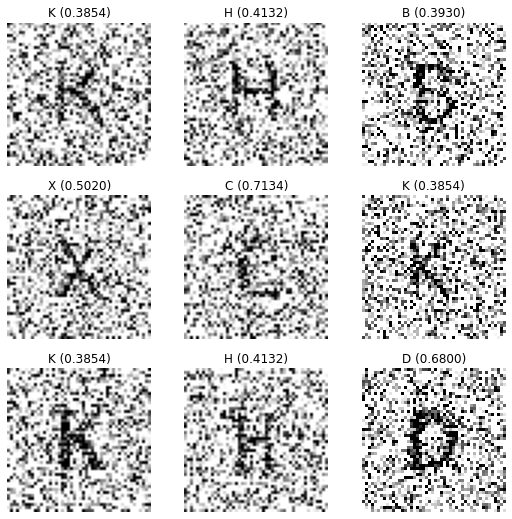

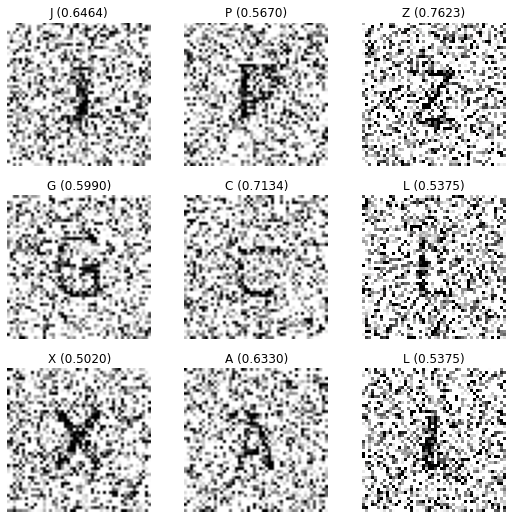

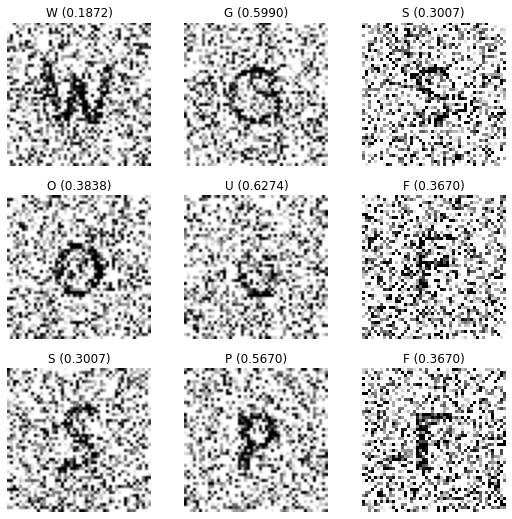

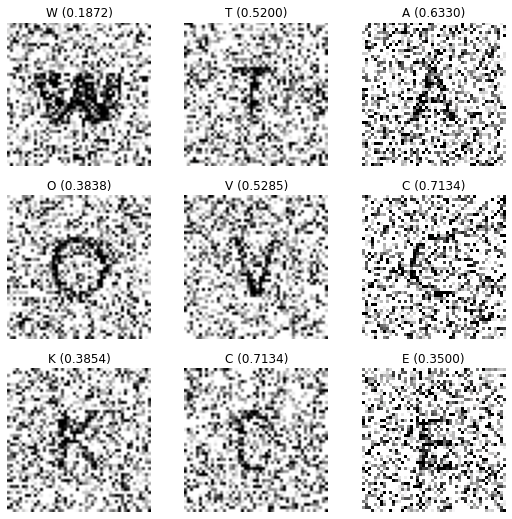

In [21]:
stats = {}
for v in versions:
    learn,learn_fn,best_fn = do_build_finetuning_learner(v)
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False)
    lr = lrs.minimum
    learn.fit_one_cycle(300, lr)
    learn.save(f"{learn_fn}_ep300")
    loss = learn.recorder.losses[-1]
    stats[v] = dict(learn_fn=learn_fn,best_fn=best_fn,lr=lr,loss=loss)

In [22]:
stats

{'v1': {'learn_fn': 'e2_cornet_z_v1_finetuned',
  'best_fn': 'e2_cornet_z_v1_finetuned_best',
  'lr': 0.002754228748381138,
  'loss': TensorBase(2.2687)},
 'v2': {'learn_fn': 'e2_cornet_z_v2_finetuned',
  'best_fn': 'e2_cornet_z_v2_finetuned_best',
  'lr': 0.0033113110810518267,
  'loss': TensorBase(2.2399)},
 'v3': {'learn_fn': 'e2_cornet_z_v3_finetuned',
  'best_fn': 'e2_cornet_z_v3_finetuned_best',
  'lr': 0.0015848932787775993,
  'loss': TensorBase(2.2357)},
 'v4': {'learn_fn': 'e2_cornet_z_v4_finetuned',
  'best_fn': 'e2_cornet_z_v4_finetuned_best',
  'lr': 0.003981071710586548,
  'loss': TensorBase(2.2439)}}

Let's check if there is any more improvement to be gained by further training.

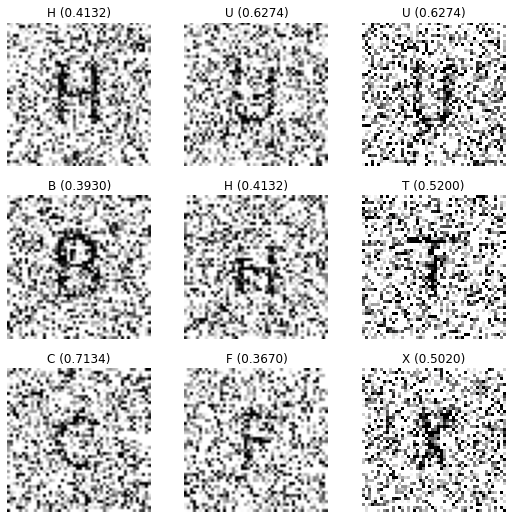

In [32]:
v = "v4"
learn,learn_fn,best_fn = do_build_finetuning_learner(v)
learn.load(best_fn)
learn.save(f"{learn_fn}_ep300_best")
lr = stats[v]["lr"] * .5
learn.fit_one_cycle(100, lr)
learn.save(f"{learn_fn}_ep400")
loss = learn.recorder.losses[-1]
loss_d = stats[v]["loss"] - loss

> The improvement was negligble. Let's save the best models as `e2_cornet_z_vX_finetuned_final.pth`.

### Evalute the finetuned models

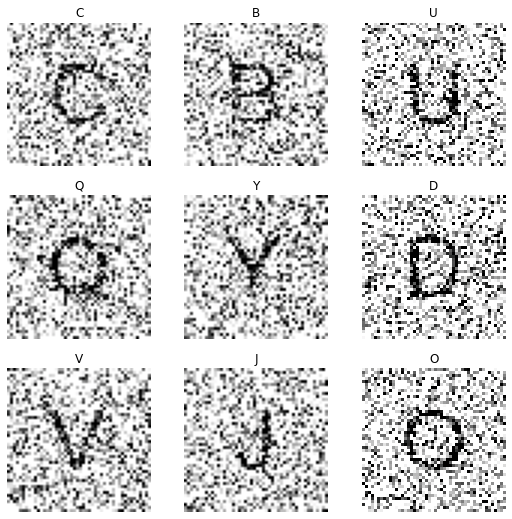

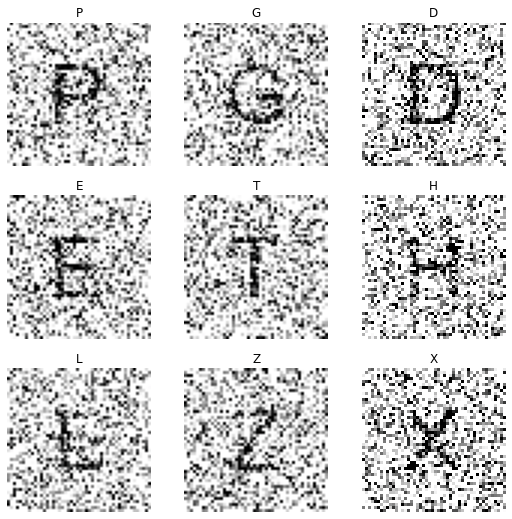

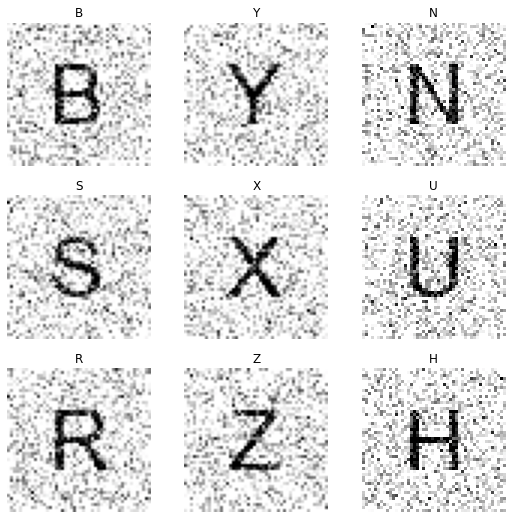

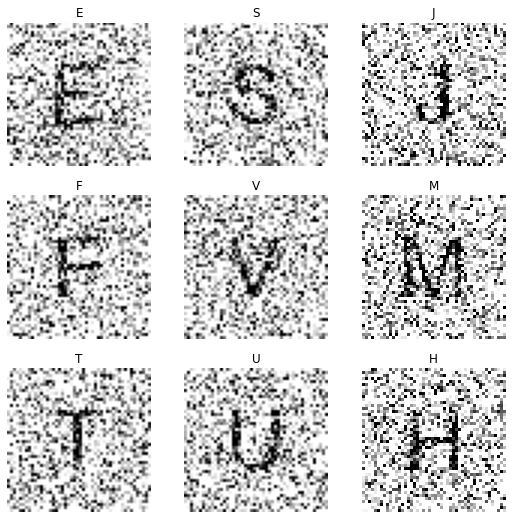

In [24]:
finetuned_suffix = "_finetuned_best.pth"
finetuned_rs = do_cm_comparison_for_versions(["v1", "v2", "v3", "v4"], fn_suffix=finetuned_suffix)
dump(finetuned_rs, DUMP_FOLDER / "ocr_model_correlations_with_vdh_after_finetuning.pkl")

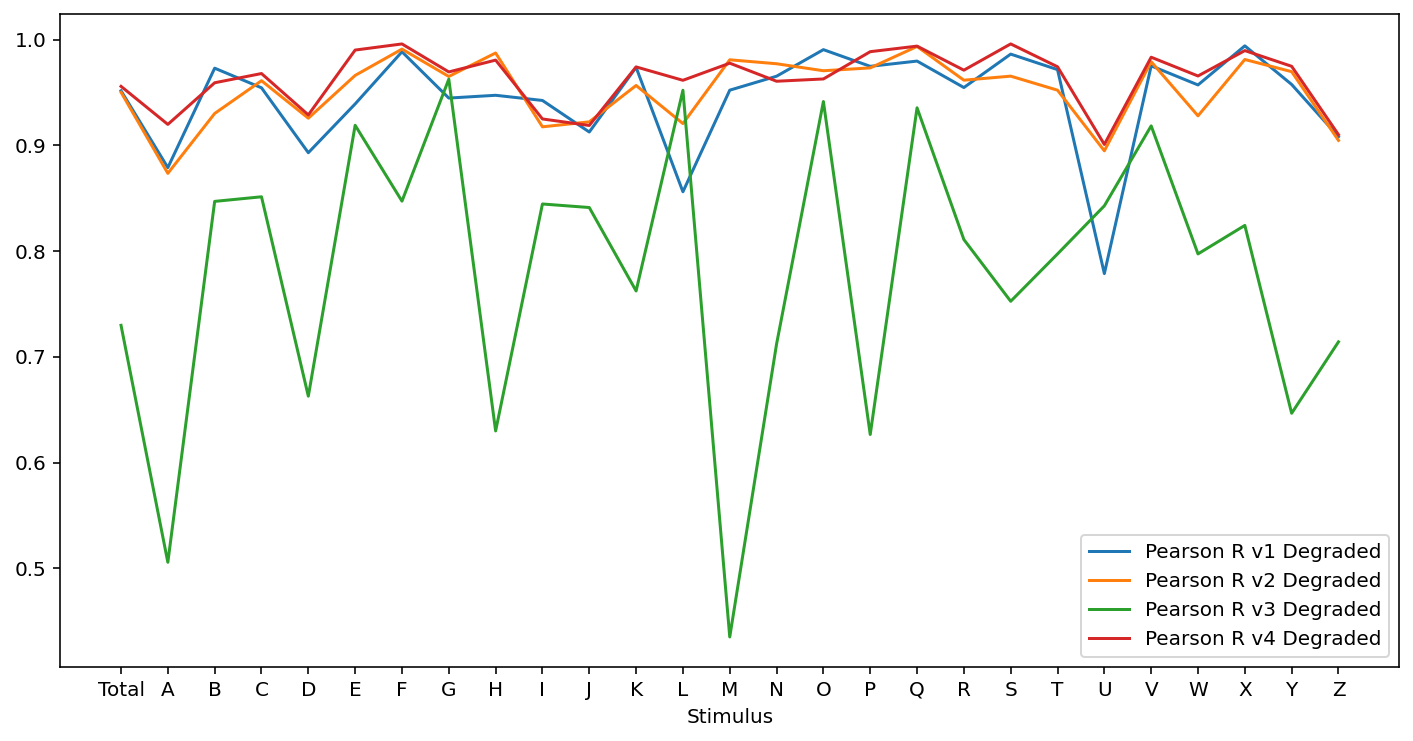

In [30]:
plot_cm_comparisons(finetuned_rs, incl_suffix="Degraded")

In [31]:
for c,v in zip(finetuned_rs.columns, finetuned_rs.loc["Total"]): 
    if c.endswith("Degraded"): print(f"{c:<25} {v}")

Pearson R v1 Degraded     0.951620120799788
p v1 Degraded             1.3822945046363566e-167
Pearson R v2 Degraded     0.9502371755015762
p v2 Degraded             1.1703300208494953e-165
Pearson R v3 Degraded     0.7298405393971668
p v3 Degraded             2.6745432106365273e-55
Pearson R v4 Degraded     0.955784466607984
p v4 Degraded             9.444910280337565e-174


> Versions 1, 2 and 4 perform almost identically, but v4 has a slightly higher R and its per-category correlations are more even, so we'll choose that. We'll save that as `FINETUNED_OCR_MODEL_FN` (§Common variables), `e2_cornet_z_v4_finetuned_final.pth`.

# Final Results

| Version | Trained layers* | Dataset | Training | Accuracy | CM fine-tuning | Pearson R With Empirical CM | Model path | 
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| v1 • Alt  | V4–decoder | Fonts only | 10ep@2e-3 • 10ep@2e-4 • 20ep@1e-4 (stopped at ep0) | 0.982 | 300ep@2.75e-3 | 0.951620120799788 | e2_cornet_z_v1_finetuned_final.pth | 
| v2(b) | V2–decoder | Fonts only | *similar* |  0.959 | 300ep@3.31e-3 | 0.9502371755015762 | e2_cornet_z_v2_finetuned_final.pth | 
| v3 | V4–decoder | Fonts and handwritten | *similar* | 0.988 | 300ep@1.58e-3 | 0.7298405393971668 | e2_cornet_z_v3_finetuned_final.pth | 
| v4 • Primary  | V2–decoder | Fonts and handwritten | *similar* | 0.965 | 300ep@3.98e-3 | 0.955784466607984 | e2_cornet_z_v4_finetuned_final.pth | 

\* Note that empirical CM (confusion matrix) finetuning is only done for the Decoder layer.

Of these, v4 is selected as the defaul, but we'll also use v1 as an alternative.

Training details list `max_lr`’s using `one_cycle`.

See §Statistics under Step 1 for more details.

# Additional Visualisations

## Noisy Letters

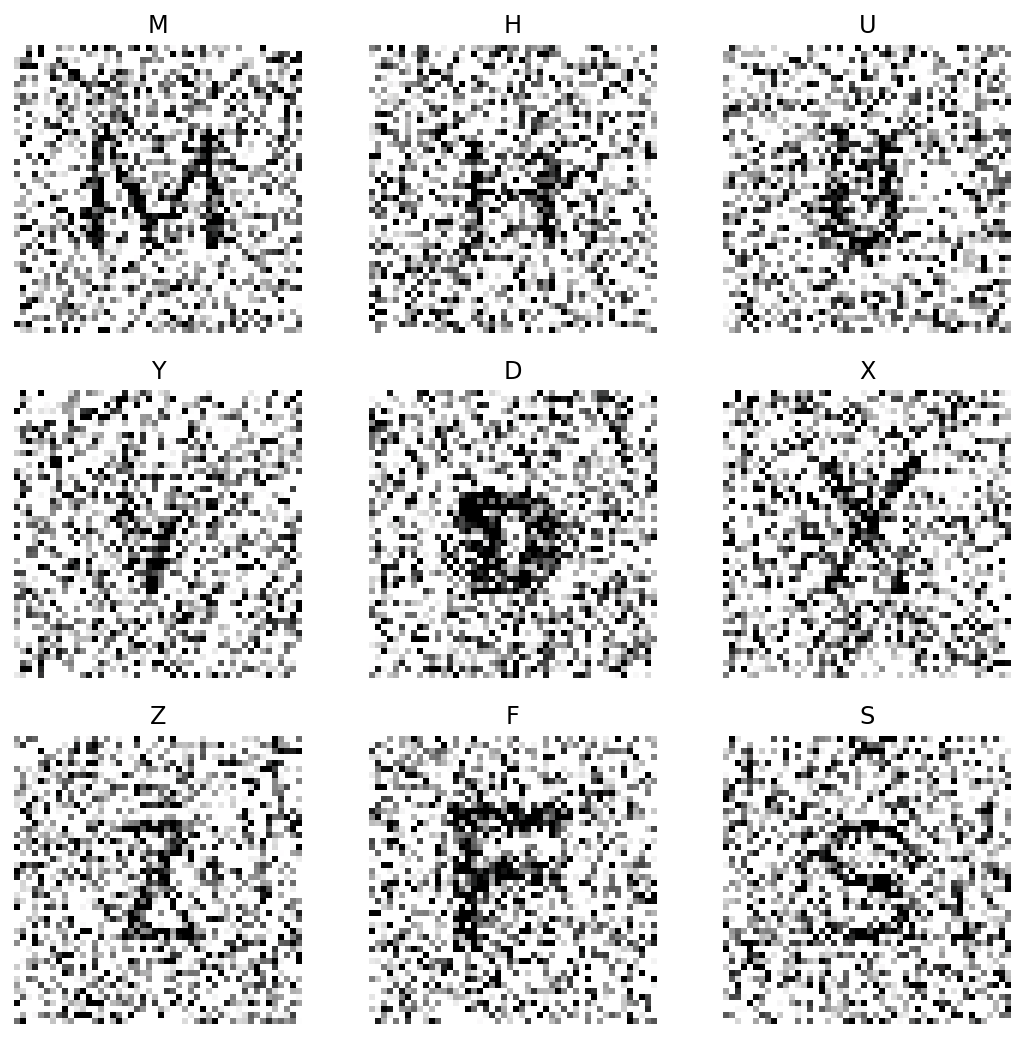

In [14]:
# sans_serif_df = get_sans_serif_df()
# ocr_model = load_ocr_model(file=BASE_OCR_MODEL_FN, arch=cornet_for_ocr, n_out=26)
# learn = build_ocr_learner(ocr_model, df=sans_serif_df, valid_pct=0., **ACC_50_TFMS)
plt.rcParams['figure.dpi'] = 144
learn.dls.show_batch()
